### 1. Imports

In [23]:
import os, random, itertools, math
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
from PIL import Image
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.transforms import functional as TF
import torch.nn.functional as F

from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation, get_cosine_schedule_with_warmup

### 2. Globals

In [24]:
DATA_DIR   = Path("data/SegFormer")
IMG_SIZE   = 512
BATCH_SIZE = 8
ACC_STEPS  = 4
EPOCHS     = 40
LR         = 5e-5
NUM_WORKERS= min(os.cpu_count() // 2 or 1, 8)
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED       = 42
random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

### 3. Utils

In [25]:
# Image processor
processor = SegformerImageProcessor(size=IMG_SIZE, reduce_labels=False)

# Colour map
def discover_colors() -> Dict[Tuple[int, int, int], int]:
    paths  = list(itertools.chain.from_iterable(
        (DATA_DIR / split).glob("*_mask.png") for split in ("train", "val")))
    colors = torch.empty((0, 3), dtype=torch.uint8, device=DEVICE)
    for p in tqdm(paths, desc="Scanning masks"):
        arr = torch.as_tensor(np.array(Image.open(p).convert("RGB")), device=DEVICE, dtype=torch.uint8)
        colors = torch.unique(torch.cat((colors, arr.view(-1, 3))), dim=0)
    return {tuple(c): i for i, c in enumerate(sorted(colors.cpu().tolist()))}

COLOR_MAP = discover_colors()
N_CLASSES = len(COLOR_MAP)

print(N_CLASSES)

Scanning masks:   0%|          | 0/1301 [00:00<?, ?it/s]

3


### 4. Utils - compute number of classes

In [26]:
def rgb_to_label(mask: Image.Image) -> torch.Tensor:
    arr=np.array(mask.convert("RGB"))
    lab=np.zeros(arr.shape[:2],dtype=np.uint8)
    for col,idx in COLOR_MAP.items():
        lab[np.all(arr==col,axis=-1)]=idx
    return torch.as_tensor(lab,dtype=torch.long)

def rand_crop(img:Image.Image, mask:Image.Image, size:int):
    if img.width==size and img.height==size: return img,mask
    m=np.array(mask.convert("L")); ys,xs=np.where(m>0)
    if xs.size:
        cx,cy=int(xs.mean()),int(ys.mean())
        left=max(0,min(cx-size//2,img.width-size))
        top =max(0,min(cy-size//2,img.height-size))
    else:
        left=random.randint(0,img.width-size)
        top =random.randint(0,img.height-size)
    return TF.crop(img,top,left,size,size), TF.crop(mask,top,left,size,size)

### 5. Dataset

In [ ]:
def load_pairs(split:str)->List[Tuple[str,str]]:
    masks=sorted((DATA_DIR/split).glob("*_mask.png"))
    return [(str(m.with_name(m.name.replace("_mask.png",".jpg"))), str(m)) for m in masks]

class SegDataset(Dataset):
    def __init__(self,split:str):
        self.pairs=load_pairs(split)
        self.split=split
        self.jitter=T.ColorJitter(0.3,0.3,0.3,0.1) if split=="train" else None
    def __len__(self): return len(self.pairs)
    def __getitem__(self,idx):
        img_p,mask_p=self.pairs[idx]
        img=Image.open(img_p).convert("RGB")
        mask=Image.open(mask_p).convert("RGB")
        img,mask=rand_crop(img,mask,IMG_SIZE)
        if self.split=="train":
            if random.random()<0.5: img,mask=TF.hflip(img),TF.hflip(mask)
            if self.jitter: img=self.jitter(img)
        pv=processor(images=img,return_tensors="pt").pixel_values.squeeze(0)
        lab=rgb_to_label(mask)
        return pv,lab

def make_loader(split:str):
    return DataLoader(SegDataset(split),batch_size=BATCH_SIZE, shuffle=(split=="train"),num_workers=NUM_WORKERS, pin_memory=True)

train_loader = make_loader("train")
val_loader = make_loader("val")

### 6. Network

In [28]:
model=SegformerForSemanticSegmentation.from_pretrained( "nvidia/segformer-b0-finetuned-ade-512-512", num_labels=N_CLASSES, ignore_mismatched_sizes=True).to(DEVICE)

optim=torch.optim.AdamW(model.parameters(),lr=LR,weight_decay=1e-4)
steps_total=EPOCHS*len(train_loader)//ACC_STEPS
sched=get_cosine_schedule_with_warmup(optim,len(train_loader),steps_total)
scaler=torch.amp.GradScaler(enabled=DEVICE.type=="cuda")
autocast=torch.amp.autocast

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 7. Training phase

In [29]:
def train_epoch(ep:int):
    model.train(); tot=0.
    prog=tqdm(enumerate(train_loader),total=len(train_loader), desc=f"Epoch {ep}",leave=False)
    optim.zero_grad(set_to_none=True)
    for i,(pix,lab) in prog:
        pix,lab=pix.to(DEVICE),lab.to(DEVICE)
        with autocast(device_type="cuda",enabled=DEVICE.type=="cuda", dtype=torch.float16):
            loss=model(pixel_values=pix,labels=lab).loss/ACC_STEPS
        scaler.scale(loss).backward(); tot+=loss.item()*ACC_STEPS
        if (i+1)%ACC_STEPS==0:
            scaler.step(optim); scaler.update(); sched.step()
            optim.zero_grad(set_to_none=True)
        prog.set_postfix(loss=f"{tot/(i+1):.4f}")
    return tot/len(train_loader)

# Evaluate (fix shape mismatch between logits and labels)

@torch.no_grad()
def evaluate():
    model.eval()
    conf = torch.zeros((N_CLASSES, N_CLASSES), dtype=torch.int64)  # keep on CPU
    for pix, lab in val_loader:
        pix, lab = pix.to(DEVICE), lab.to(DEVICE)
        with autocast(device_type="cuda", enabled=DEVICE.type == "cuda", dtype=torch.float16):
            logits = model(pixel_values=pix).logits                 # (B,C,h',w')
        logits = F.interpolate(logits, size=lab.shape[-2:], mode="bilinear", align_corners=False)                 # up-sample to label size
        pred = torch.argmax(logits, 1)

        lab_flat  = lab.view(-1).cpu()
        pred_flat = pred.view(-1).cpu()
        conf.index_put_((lab_flat, pred_flat), torch.ones_like(lab_flat), accumulate=True)

    iu = torch.diag(conf) / (conf.sum(1) + conf.sum(0) - torch.diag(conf) + 1e-6)
    return iu.mean().item()

# Loop
best=0.
for ep in range(1,EPOCHS+1):
    train_loss=train_epoch(ep)
    miou=evaluate()
    print(f"Epoch {ep}: loss {train_loss:.4f} | mIoU {miou*100:.2f}%")
    if miou>best:
        best=miou
        torch.save(model.state_dict(),"segformer_b0_best.pth")
        print("saved best")

Epoch 1:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 1: loss 1.0994 | mIoU 35.47%
saved best


Epoch 2:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 2: loss 0.9882 | mIoU 43.05%
saved best


Epoch 3:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 3: loss 0.8961 | mIoU 46.66%
saved best


Epoch 4:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 4: loss 0.7827 | mIoU 56.04%
saved best


Epoch 5:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 5: loss 0.6731 | mIoU 61.77%
saved best


Epoch 6:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 6: loss 0.5997 | mIoU 63.84%
saved best


Epoch 7:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 7: loss 0.5526 | mIoU 66.30%
saved best


Epoch 8:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 8: loss 0.5246 | mIoU 66.18%


Epoch 9:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 9: loss 0.5056 | mIoU 67.54%
saved best


Epoch 10:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 10: loss 0.4902 | mIoU 67.48%


Epoch 11:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 11: loss 0.4787 | mIoU 67.83%
saved best


Epoch 12:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 12: loss 0.4696 | mIoU 68.27%
saved best


Epoch 13:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 13: loss 0.4590 | mIoU 68.23%


Epoch 14:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 14: loss 0.4570 | mIoU 68.93%
saved best


Epoch 15:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 15: loss 0.4523 | mIoU 68.78%


Epoch 16:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 16: loss 0.4493 | mIoU 69.27%
saved best


Epoch 17:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 17: loss 0.4439 | mIoU 69.39%
saved best


Epoch 18:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 18: loss 0.4419 | mIoU 69.77%
saved best


Epoch 19:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 19: loss 0.4369 | mIoU 69.42%


Epoch 20:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 20: loss 0.4324 | mIoU 69.20%


Epoch 21:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 21: loss 0.4310 | mIoU 69.40%


Epoch 22:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 22: loss 0.4261 | mIoU 69.97%
saved best


Epoch 23:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 23: loss 0.4243 | mIoU 70.04%
saved best


Epoch 24:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 24: loss 0.4232 | mIoU 69.55%


Epoch 25:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 25: loss 0.4218 | mIoU 69.86%


Epoch 26:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 26: loss 0.4207 | mIoU 70.15%
saved best


Epoch 27:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 27: loss 0.4196 | mIoU 69.95%


Epoch 28:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 28: loss 0.4182 | mIoU 70.21%
saved best


Epoch 29:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 29: loss 0.4174 | mIoU 70.29%
saved best


Epoch 30:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 30: loss 0.4155 | mIoU 70.22%


Epoch 31:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 31: loss 0.4209 | mIoU 69.89%


Epoch 32:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 32: loss 0.4148 | mIoU 70.22%


Epoch 33:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 33: loss 0.4139 | mIoU 70.26%


Epoch 34:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 34: loss 0.4120 | mIoU 70.34%
saved best


Epoch 35:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 35: loss 0.4125 | mIoU 70.31%


Epoch 36:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 36: loss 0.4131 | mIoU 70.18%


Epoch 37:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 37: loss 0.4126 | mIoU 70.05%


Epoch 38:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 38: loss 0.4155 | mIoU 70.39%
saved best


Epoch 39:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 39: loss 0.4146 | mIoU 70.19%


Epoch 40:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 40: loss 0.4132 | mIoU 70.35%


### 8. Evaluation, plots, and inference on test set

/tmp/ipykernel_30673/4012063082.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", N_CLASSES)


Inference:   0%|          | 0/50 [00:00<?, ?it/s]

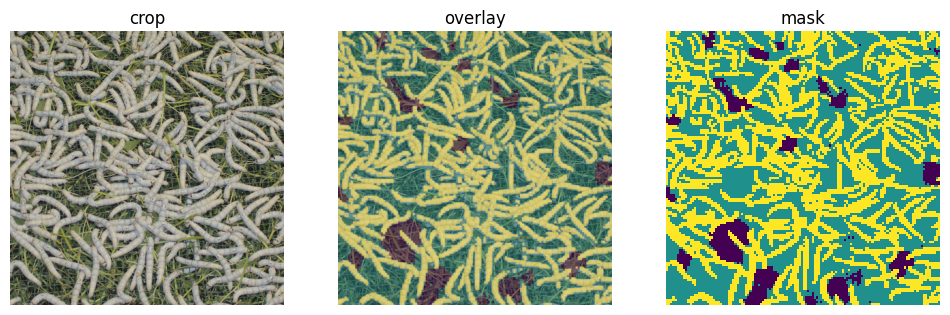

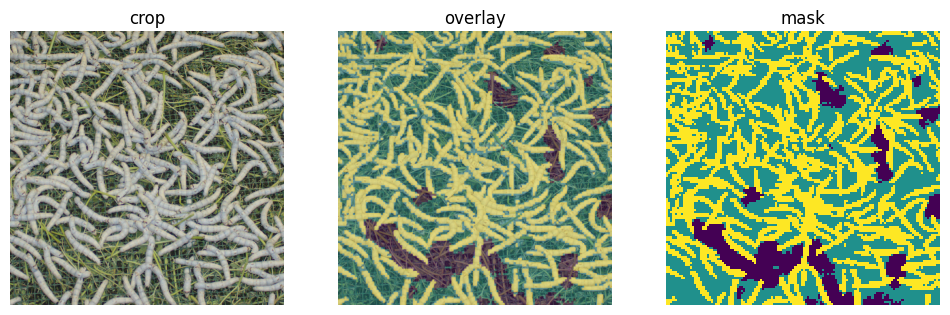

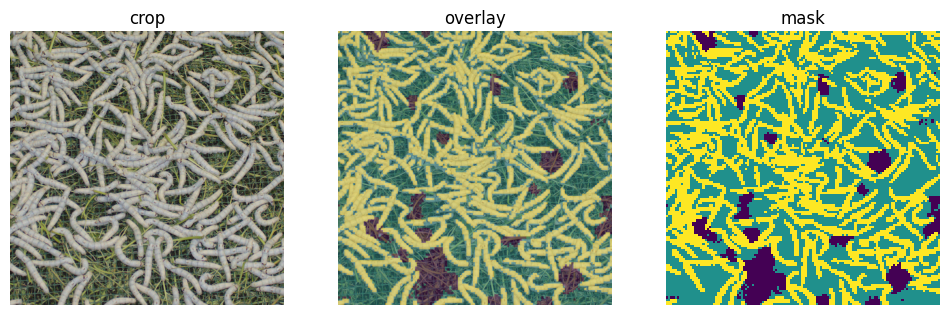

Images processed : 50
Avg crop time    : 0.38 ms
Avg infer time   : 17.13 ms
Avg total time   : 17.51 ms  |  ≈ 57.11 FPS


In [30]:
# Full-set inference + viridis masks + timing (ms / µs)
N_PRED = 3

out_dir = DATA_DIR / "inference"
out_dir.mkdir(exist_ok=True)

from matplotlib import pyplot as plt, cm
from torchvision.transforms.functional import center_crop
import time, statistics

# palette = {0: (128, 128, 128), 1: (0, 255, 0), 2: (255, 0, 0)}

cmap = cm.get_cmap("viridis", N_CLASSES)

model.load_state_dict(torch.load("segformer_b0_best.pth", map_location=DEVICE))
model.eval()

test_imgs = sorted((DATA_DIR / "test").glob("*.jpg"))

t_crop, t_inf = [], []
shown = 0
with torch.no_grad():
    for img_p in tqdm(test_imgs, desc="Inference"):
        t0 = time.perf_counter()

        img = Image.open(img_p).convert("RGB")
        t_c0 = time.perf_counter()
        img_c = center_crop(img, (IMG_SIZE, IMG_SIZE))
        t_c1 = time.perf_counter()

        pv = processor(images=img_c, return_tensors="pt").pixel_values.to(DEVICE)
        t_i0 = time.perf_counter()
        with autocast(device_type="cuda", enabled=DEVICE.type == "cuda", dtype=torch.float16):
            logits = model(pixel_values=pv).logits
        t_i1 = time.perf_counter()

        mask = torch.argmax(logits, 1).squeeze(0).cpu().numpy()

        # viridis colour mask & overlay
        colour_arr = (cmap(mask)[:, :, :3] * 255).astype(np.uint8)
        colour_img = Image.fromarray(colour_arr).resize(img_c.size, Image.NEAREST)
        overlay    = Image.blend(img_c.convert("RGB"), colour_img, alpha=0.4)

        colour_img.save(out_dir / f"{img_p.stem}_pred.png")

        if shown < N_PRED:
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1); plt.imshow(img_c);  plt.axis("off"); plt.title("crop")
            plt.subplot(1, 3, 2); plt.imshow(overlay); plt.axis("off"); plt.title("overlay")
            plt.subplot(1, 3, 3); plt.imshow(mask, cmap="viridis", interpolation="nearest")
            plt.axis("off"); plt.title("mask")
            plt.show()
            shown += 1

        t_crop.append(t_c1 - t_c0)
        t_inf.append(t_i1 - t_i0)

avg_crop = statistics.mean(t_crop)
avg_inf  = statistics.mean(t_inf)

num_imgs = len(test_imgs)
print(f"Images processed : {num_imgs}")
print(f"Avg crop time    : {avg_crop*1e3:.2f} ms")
print(f"Avg infer time   : {avg_inf*1e3:.2f} ms")
print(f"Avg total time   : {(avg_crop + avg_inf)*1e3:.2f} ms  |  ≈ {1/(avg_crop + avg_inf):.2f} FPS")
